## 2 ASCAT SSM NRT: Download, read and visualize

* Download data from the H SAF FTP
* Read data
* Visualize data on maps

### 2.1 Data download from H SAF FTP

#### 2.1.1 FTP download using terminal

Each of you should have been given a username and password for reading data from the H SAF FTP. We can use e.g. the terminal to download data.

```
ftp ftphsaf.meteoam.it
username: <your_username>
password: <your_password>
cd products/h16/h16_cur_mon_data
get h16_20181108_103300_METOPB_31863_EUM.buf
exit
```

#### 2.1.2 FTP download using ascat package

```python
import os
import datetime
from ascat.download.interface import hsaf_download

credentials = {'user': '<ftp_username>', 'password': '<ftp_password>'}
local_path = '/path/to/download/folder/'
remote_path = '/products/h16/h16_cur_mon_data'
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime(2022, 1, 2)

hsaf_download(credentials, remote_path, local_path, start_date, end_date, limit=5)
```

### 2.2 Read ASCAT SSM NRT 12.5 km sampling - Metop-B (H16)

In [1]:
import os
from datetime import datetime

import cartopy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cmcrameri.cm as cmc 
import pytesmo.grid.resample as resample

import ascat.h_saf as h_saf

/home/shahn/hsaf_miniconda/envs/sm_env/lib/python3.6/site-packages/pyresample/bilinear/__init__.py:49: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")
/home/shahn/hsaf_miniconda/envs/sm_env/lib/python3.6/site-packages/pytesmo/grid/resample.py:30: UserWarning: resampling functions have moved to the repurpose package and will beremoved from pytesmo soon!
  warn("resampling functions have moved to the repurpose package and will be"


In [2]:
# set root path to downloaded data
root_path = os.path.join(os.getcwd(), 'data', 'ssm_nrt_demo')

In [3]:
h16_path = os.path.join(root_path, 'h16')
h16_reader = h_saf.AscatNrtBufrFileList(h16_path, product_id='h16')

In [4]:
# the reader returns not only the data but also metadata, longitudes and latitudes
data, metadata = h16_reader.read(datetime(2022, 1, 17, 11, 39, 0))

In [5]:
print(type(data))

<class 'numpy.ma.core.MaskedArray'>


In [6]:
metadata

{'platform_id': 3,
 'orbit_start': 48428,
 'filename': 'h16_20220117_113900_METOPB_48428_EUM.buf'}

In [7]:
# the data is a dictionary, each dictionary key contains the array of one variable
print("The following variables are in this image", data.dtype.names)
print(data['sm'].shape)
print(data['lon'].shape)
print(data['lat'].shape)

The following variables are in this image ('lat', 'lon', 'time', 'abs_orbit_nr', 'node_num', 'sat_track_azi', 'sm', 'sm_noise', 'sig40', 'sig40_noise', 'slope40', 'slope40_noise', 'sm_sens', 'dry_sig40', 'wet_sig40', 'sm_mean', 'rf', 'corr_flag', 'proc_flag', 'agg_flag', 'snow_prob', 'frozen_prob', 'wetland', 'topo', 'inc', 'sig', 'azi', 'f_usable', 'beam_num', 'kp_noise', 'kp', 'f_land', 'swath_indicator', 'line_num', 'sat_id', 'as_des_pass')
(7872,)
(7872,)
(7872,)


In [8]:
print(sum(data['sm'].mask == False))

3936


### 2.3 Visualize data on a map

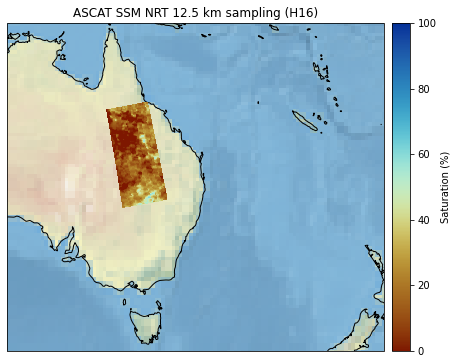

In [9]:
# define projection
plot_crs = cartopy.crs.Mercator()
data_crs = cartopy.crs.PlateCarree()

# create figure and background
fig = plt.figure(figsize=(7, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=plot_crs)
ax.set_title('ASCAT SSM NRT 12.5 km sampling (H16)')
ax.coastlines()
ax.stock_img()
ax.set_extent([130, 175, -10, -42])

# plot data
sc = ax.scatter(data['lon'], data['lat'], c=data['sm'], zorder=3, marker='s', s=2,
                transform=data_crs, cmap=cmc.roma, vmin=0, vmax=100)

# create colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cb1 = plt.colorbar(sc, cax=ax_cb)
cb1.set_label('Saturation (%)')

In [10]:
# lets resample to a 0.1 degree grid
# define the grid points in latitude and logitude
lats_dim = np.arange(-80, 80, 0.1)
lons_dim = np.arange(-160, 170, 0.1)

# make 2d grid out the 1D grid spacings
lons_grid, lats_grid = np.meshgrid(lons_dim, lats_dim)
    
resampled_data = resample.resample_to_grid({'sm': data['sm']}, 
                                           data['lon'], data['lat'], 
                                           lons_grid, lats_grid)

/home/shahn/hsaf_miniconda/envs/sm_env/lib/python3.6/site-packages/pyresample/kd_tree.py:383: UserWarning: Possible more than 8 neighbours within 18000 m for some data points
  (neighbours, radius_of_influence))


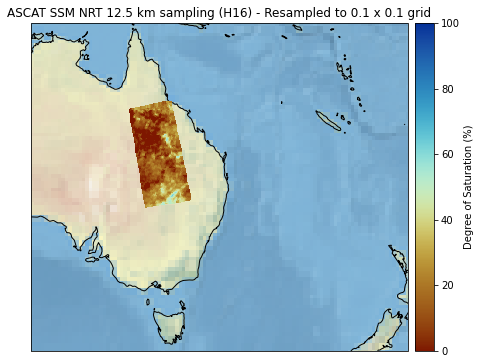

In [11]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=plot_crs)
ax.set_title('ASCAT SSM NRT 12.5 km sampling (H16) - Resampled to 0.1 x 0.1 grid')
ax.coastlines()
ax.stock_img()
ax.set_extent([130, 175, -10, -42])

sc = ax.pcolormesh(lons_grid, lats_grid, resampled_data['sm'], zorder=3, 
                   cmap=cmc.roma, vmin=0, vmax=100, transform=data_crs)

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cb1 = plt.colorbar(sc, cax=ax_cb)
cb1.set_label('Degree of Saturation (%)')

In [12]:
# lets resample to a 0.1 degree grid
# define the grid points in latitude and logitude
lats_dim = np.arange(-80, 80, 0.1)
lons_dim = np.arange(-160, 170, 0.1)

# make 2d grid out the 1D grid spacings
lons_grid, lats_grid = np.meshgrid(lons_dim, lats_dim)

resampled_sm = resample.resample_to_grid({'sm': data['sm']}, 
                                         data['lon'], data['lat'], 
                                         lons_grid, lats_grid)

resampled_sm_mean = resample.resample_to_grid({'sm_mean': data['sm_mean']}, 
                                              data['lon'], data['lat'], 
                                              lons_grid, lats_grid)

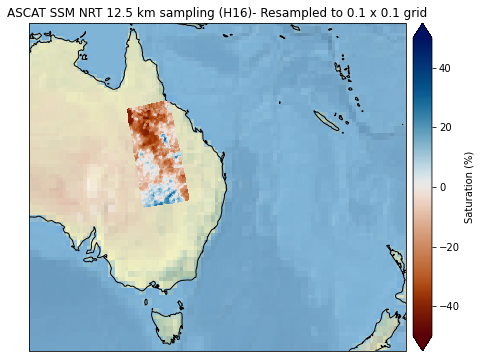

In [13]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=plot_crs)
ax.set_title('ASCAT SSM NRT 12.5 km sampling (H16)- Resampled to 0.1 x 0.1 grid')
ax.coastlines()
ax.stock_img()
ax.set_extent([130, 175, -10, -42])

anomaly = resampled_sm['sm'] - resampled_sm_mean['sm_mean']

sc = ax.pcolormesh(lons_grid, lats_grid, anomaly, zorder=3, 
                   cmap=cmc.vik_r, vmin=-50, vmax=50, transform=data_crs)

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cb1 = plt.colorbar(sc, cax=ax_cb, extend='both')
cb1.set_label('Saturation (%)')